In [1]:
# Ames Housing Market Descriptive Analysis
# A Data-Driven Understanding of Housing Prices in Ames, Iowa (2006-2010)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Ames Housing Market Analysis")
print("="*50)

# Load the data
housing = pd.read_csv('Ames_HousePrice.csv', index_col=0)
print(f"Dataset shape: {housing.shape}")
print(f"Analysis period: {housing['YrSold'].min()}-{housing['YrSold'].max()}")

Ames Housing Market Analysis
Dataset shape: (2580, 81)
Analysis period: 2006-2010



PHASE 1: FOUNDATIONAL PRICE/AREA ANALYSIS

Basic Price Statistics:
Mean Sale Price: $178,060
Median Sale Price: $159,900
Price Range: $12,789 - $755,000

Mean Living Area: 1,486 sq ft
Living Area Range: 334 - 4,676 sq ft

Price per Sq Ft Statistics:
Mean: $120.90
Median: $119.64
Range: $15.37 - $276.25


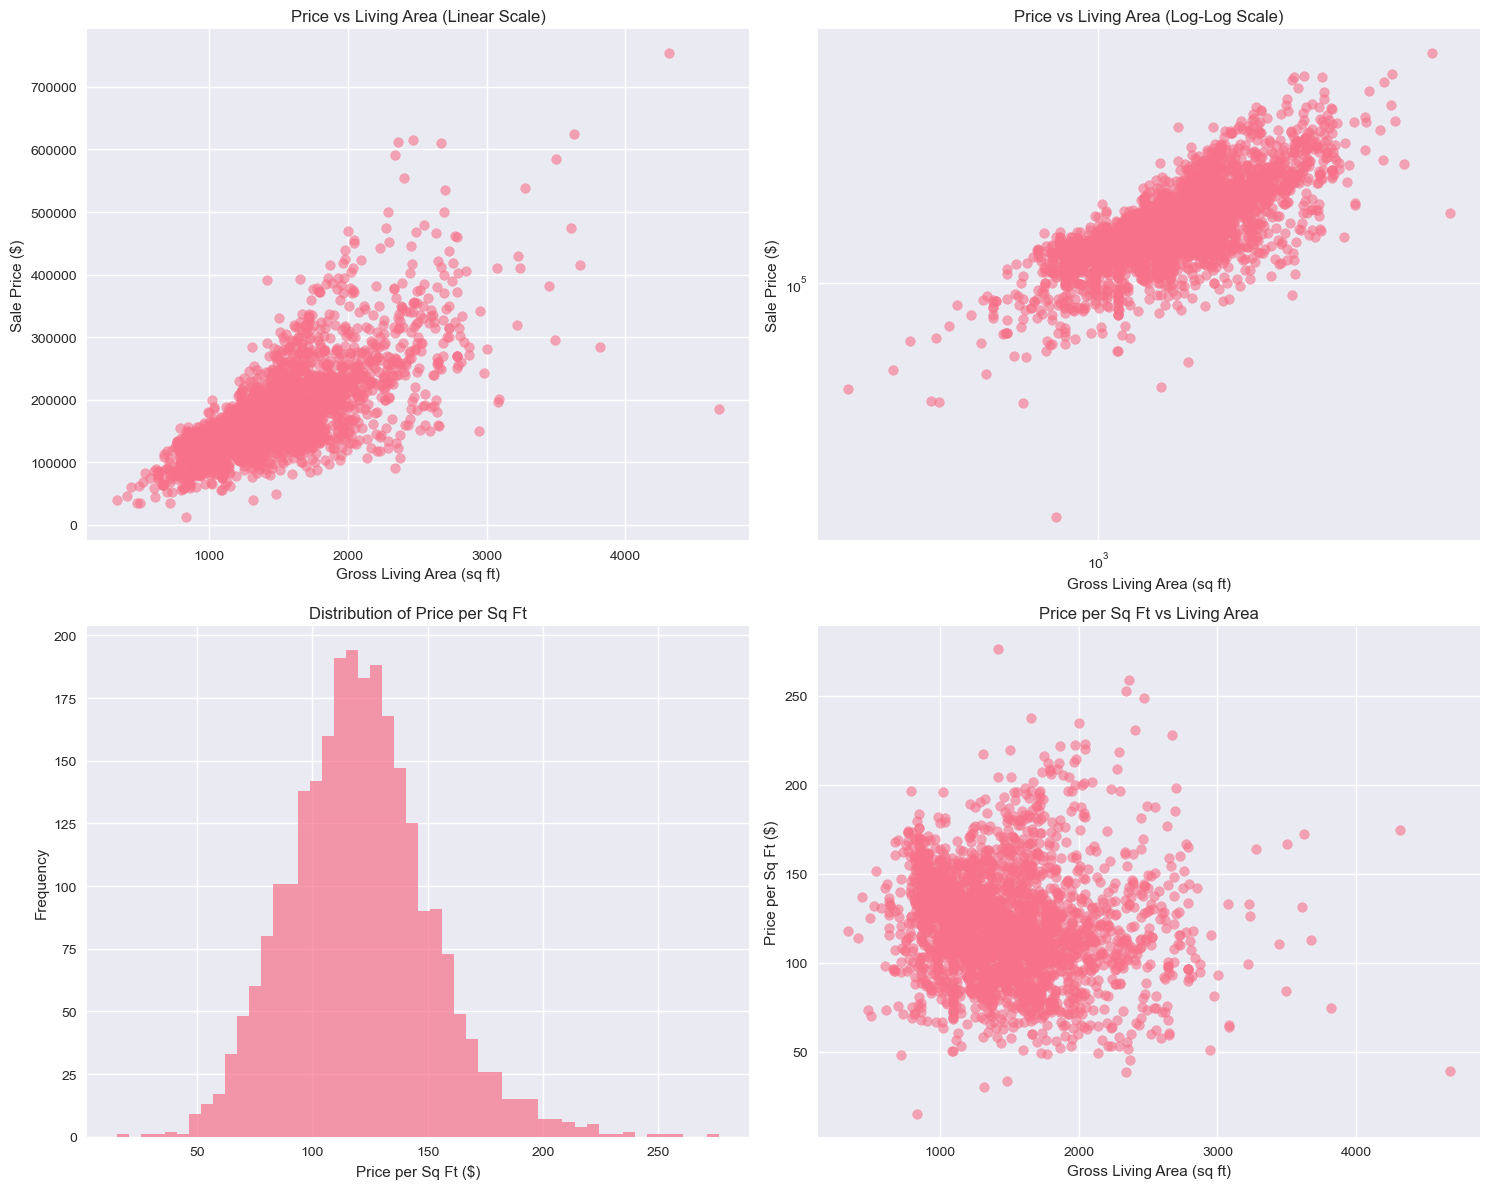


------------------------------
LOG-LOG REGRESSION ANALYSIS
------------------------------
Linear Model R²: 0.5184
Log-Log Model R²: 0.5401
Log-Log Model: log(price) = 2.442 + 0.881 * log(area)

Model Interpretation:
Price = 10^2.44 * Area^0.881
Price/SqFt ≈ 276.9 * Area^-0.119
The negative exponent (-0.119) suggests larger homes have lower price per sq ft


In [2]:
# ==========================================
# PHASE 1: FOUNDATIONAL ANALYSIS
# ==========================================

print("\n" + "="*50)
print("PHASE 1: FOUNDATIONAL PRICE/AREA ANALYSIS")
print("="*50)

# Basic statistics
print("\nBasic Price Statistics:")
print(f"Mean Sale Price: ${housing['SalePrice'].mean():,.0f}")
print(f"Median Sale Price: ${housing['SalePrice'].median():,.0f}")
print(f"Price Range: ${housing['SalePrice'].min():,.0f} - ${housing['SalePrice'].max():,.0f}")

print(f"\nMean Living Area: {housing['GrLivArea'].mean():,.0f} sq ft")
print(f"Living Area Range: {housing['GrLivArea'].min():,.0f} - {housing['GrLivArea'].max():,.0f} sq ft")

# Calculate price per square foot
housing['PricePerSqFt'] = housing['SalePrice'] / housing['GrLivArea']
print(f"\nPrice per Sq Ft Statistics:")
print(f"Mean: ${housing['PricePerSqFt'].mean():.2f}")
print(f"Median: ${housing['PricePerSqFt'].median():.2f}")
print(f"Range: ${housing['PricePerSqFt'].min():.2f} - ${housing['PricePerSqFt'].max():.2f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Original scatter plot
axes[0,0].scatter(housing['GrLivArea'], housing['SalePrice'], alpha=0.6)
axes[0,0].set_xlabel('Gross Living Area (sq ft)')
axes[0,0].set_ylabel('Sale Price ($)')
axes[0,0].set_title('Price vs Living Area (Linear Scale)')

# Log-log scatter plot
axes[0,1].scatter(housing['GrLivArea'], housing['SalePrice'], alpha=0.6)
axes[0,1].set_xlabel('Gross Living Area (sq ft)')
axes[0,1].set_ylabel('Sale Price ($)')
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,1].set_title('Price vs Living Area (Log-Log Scale)')

# Price per sq ft distribution
axes[1,0].hist(housing['PricePerSqFt'], bins=50, alpha=0.7)
axes[1,0].set_xlabel('Price per Sq Ft ($)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Price per Sq Ft')

# Price per sq ft vs area
axes[1,1].scatter(housing['GrLivArea'], housing['PricePerSqFt'], alpha=0.6)
axes[1,1].set_xlabel('Gross Living Area (sq ft)')
axes[1,1].set_ylabel('Price per Sq Ft ($)')
axes[1,1].set_title('Price per Sq Ft vs Living Area')

plt.tight_layout()
plt.show()

# Log-log regression analysis
print("\n" + "-"*30)
print("LOG-LOG REGRESSION ANALYSIS")
print("-"*30)

# Fit linear model
lm_linear = LinearRegression()
X_area = housing[['GrLivArea']]
y_price = housing['SalePrice']
lm_linear.fit(X_area, y_price)
r2_linear = lm_linear.score(X_area, y_price)

# Fit log-log model
lm_log = LinearRegression()
X_log = np.log10(housing[['GrLivArea']])
y_log = np.log10(housing['SalePrice'])
lm_log.fit(X_log, y_log)
r2_log = lm_log.score(X_log, y_log)

print(f"Linear Model R²: {r2_linear:.4f}")
print(f"Log-Log Model R²: {r2_log:.4f}")
print(f"Log-Log Model: log(price) = {lm_log.intercept_:.3f} + {lm_log.coef_[0]:.3f} * log(area)")

# Interpret the log-log model
beta_0, beta_1 = lm_log.intercept_, lm_log.coef_[0]
print(f"\nModel Interpretation:")
print(f"Price = 10^{beta_0:.2f} * Area^{beta_1:.3f}")
print(f"Price/SqFt ≈ {10**beta_0:.1f} * Area^{beta_1-1:.3f}")
print(f"The negative exponent ({beta_1-1:.3f}) suggests larger homes have lower price per sq ft")

In [3]:
# ==========================================
# PHASE 2: FEATURE ENGINEERING
# ==========================================

print("\n" + "="*50)
print("PHASE 2: FEATURE ENGINEERING")
print("="*50)

# Create aggregate features
print("Creating aggregate features...")

# Total bathrooms
housing['TotalBath'] = (housing['FullBath'] + 
                       housing['HalfBath'] * 0.5 + 
                       housing['BsmtFullBath'].fillna(0) + 
                       housing['BsmtHalfBath'].fillna(0) * 0.5)

# Total area (including basement)
housing['TotalArea'] = (housing['GrLivArea'] + 
                       housing['TotalBsmtSF'].fillna(0))

# Lot utilization ratio
housing['LotUtilization'] = housing['GrLivArea'] / housing['LotArea']

# Age of house when sold
housing['HouseAge'] = housing['YrSold'] - housing['YearBuilt']

# Time since remodel
housing['TimeSinceRemodel'] = housing['YrSold'] - housing['YearRemodAdd']

# Has remodeling (if remodel year different from built year)
housing['HasRemodel'] = (housing['YearRemodAdd'] != housing['YearBuilt']).astype(int)

# Garage info
housing['HasGarage'] = (housing['GarageCars'].fillna(0) > 0).astype(int)
housing['GarageArea'] = housing['GarageArea'].fillna(0)

# Pool info
housing['HasPool'] = (housing['PoolArea'] > 0).astype(int)

# Quality score (combining overall metrics)
housing['QualityScore'] = housing['OverallQual'] * housing['OverallCond']

print("Engineered features created:")
for feature in ['TotalBath', 'TotalArea', 'LotUtilization', 'HouseAge', 
                'TimeSinceRemodel', 'HasRemodel', 'HasGarage', 'HasPool', 'QualityScore']:
    print(f"- {feature}")

# Encode categorical variables for analysis
categorical_features = ['MSZoning', 'HouseStyle', 'Neighborhood', 'ExterQual', 
                       'KitchenQual', 'HeatingQC', 'CentralAir']

le_dict = {}
for feature in categorical_features:
    if feature in housing.columns:
        le = LabelEncoder()
        housing[f'{feature}_encoded'] = le.fit_transform(housing[feature].fillna('Missing'))
        le_dict[feature] = le

print(f"\nEncoded {len(categorical_features)} categorical features")


PHASE 2: FEATURE ENGINEERING
Creating aggregate features...
Engineered features created:
- TotalBath
- TotalArea
- LotUtilization
- HouseAge
- TimeSinceRemodel
- HasRemodel
- HasGarage
- HasPool
- QualityScore

Encoded 7 categorical features



PHASE 3: KEY INSIGHTS ANALYSIS

1. NEIGHBORHOOD ANALYSIS
-------------------------
Top 10 Most Expensive Neighborhoods:
              SalePrice_mean  PricePerSqFt_mean  GrLivArea_mean
Neighborhood                                                   
NoRidge            326114.30             132.55         2452.93
NridgHt            313662.50             162.93         1920.47
StoneBr            305307.93             165.61         1841.72
GrnHill            280000.00             198.66         1398.50
Veenker            251263.04             146.32         1790.00
Timber             242909.52             143.67         1699.41
Somerst            228761.85             142.76         1607.29
ClearCr            213980.80             125.21         1777.18
Crawfor            201988.95             119.79         1705.03
CollgCr            198133.17             136.97         1477.17

Bottom 5 Least Expensive Neighborhoods:
              SalePrice_mean  PricePerSqFt_mean  GrLivArea_mean
Neighb

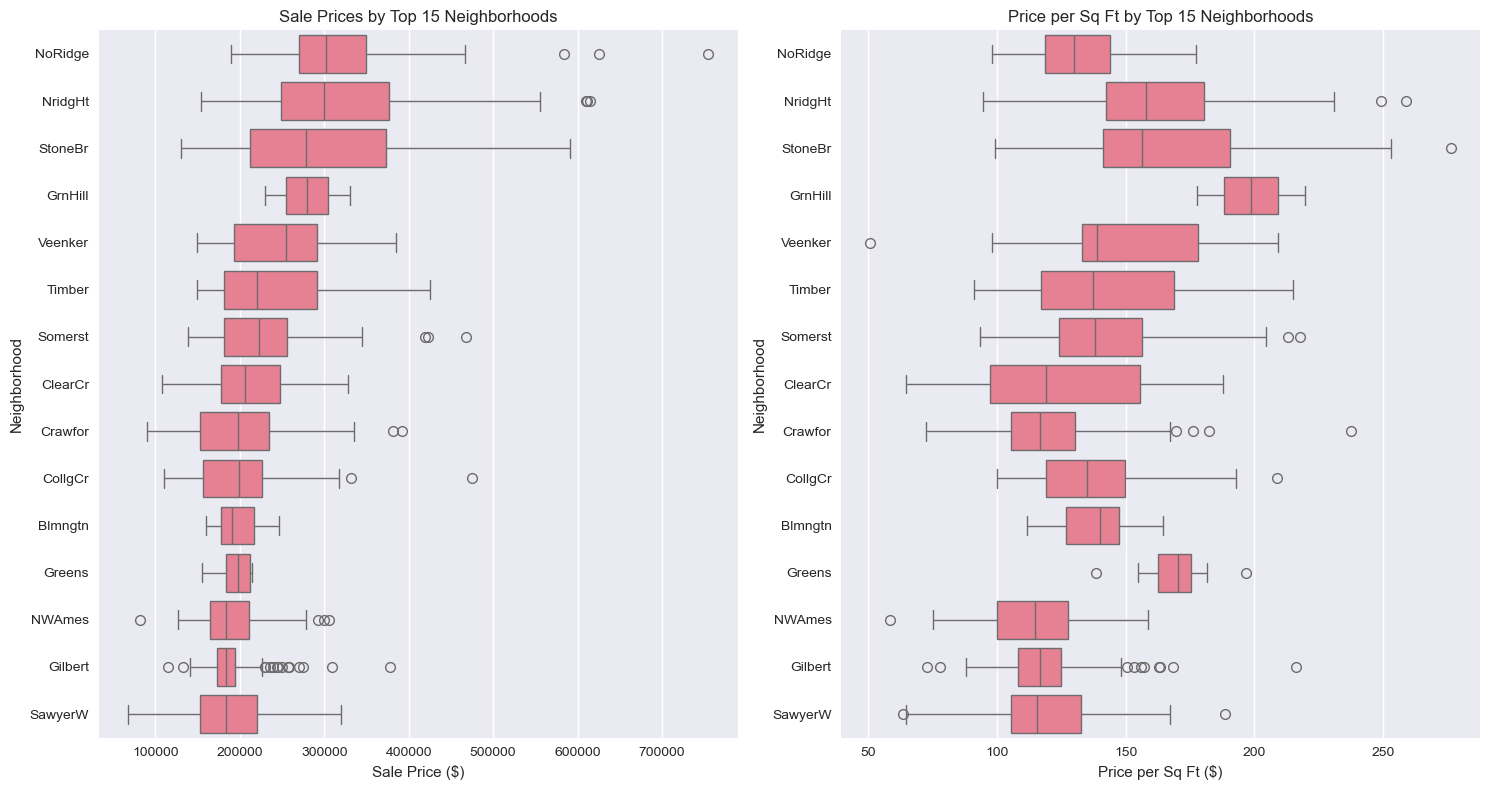


2. QUALITY VS PRICE ANALYSIS
----------------------------
Price by Overall Quality Rating:
             SalePrice       PricePerSqFt
                  mean count         mean
OverallQual                              
1             60600.00     3        78.69
2             52325.31    13        85.27
3             86526.56    32        89.18
4            107910.99   195        99.10
5            136021.31   753       113.77
6            162635.55   669       115.39
7            204691.16   525       124.36
8            268912.64   290       146.04
9            359806.60    80       178.67
10           463051.10    20       180.58


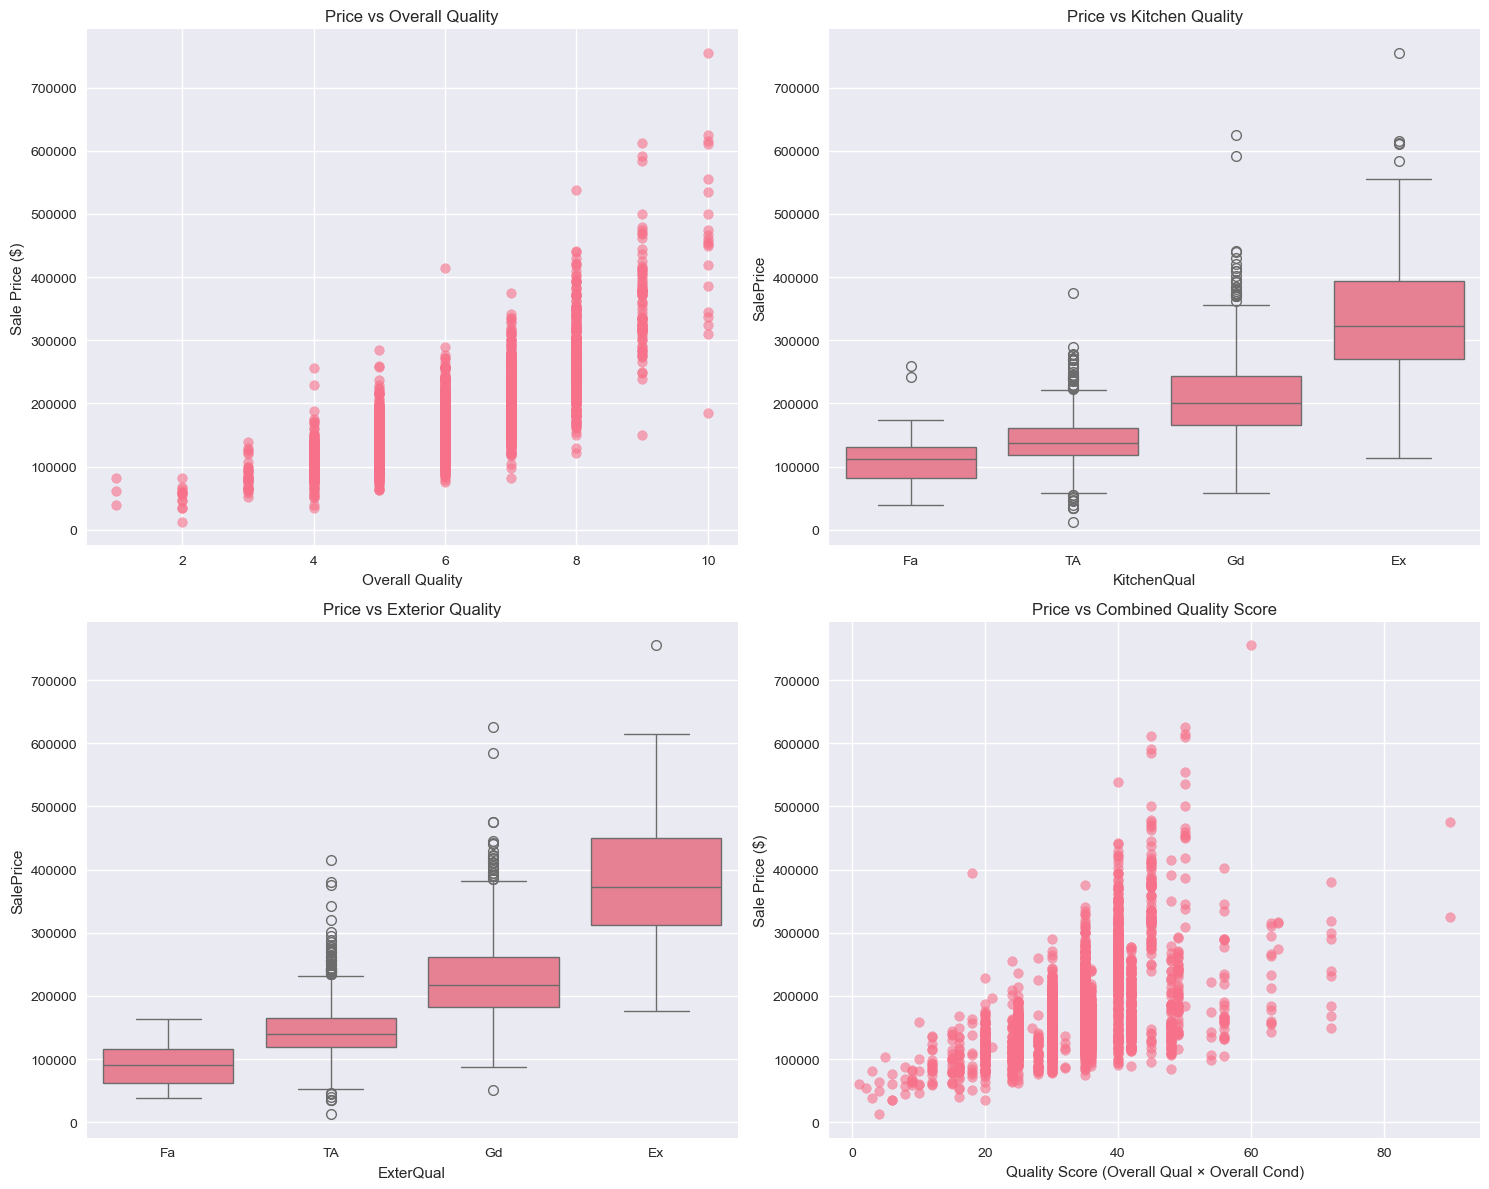


3. TIME TRENDS ANALYSIS (2006-2010)
-----------------------------------
Price Trends by Year:
        SalePrice                 PricePerSqFt        
             mean    median count         mean  median
YrSold                                                
2006    176649.31  157000.0   516       119.36  118.98
2007    179045.08  159000.0   600       122.15  120.75
2008    178170.02  162700.0   564       120.72  118.58
2009    180387.64  162000.0   585       121.48  119.69
2010    173971.67  157900.0   315       120.33  119.96

Monthly Seasonality:
        SalePrice      
             mean count
MoSold                 
1       193856.23   101
2       177285.60   121
3       174941.90   209
4       167049.78   252
5       172817.12   363
6       181035.04   459
7       180450.00   400
8       183253.90   193
9       183824.37   131
10      173962.53   148
11      179970.95   117
12      179577.24    86


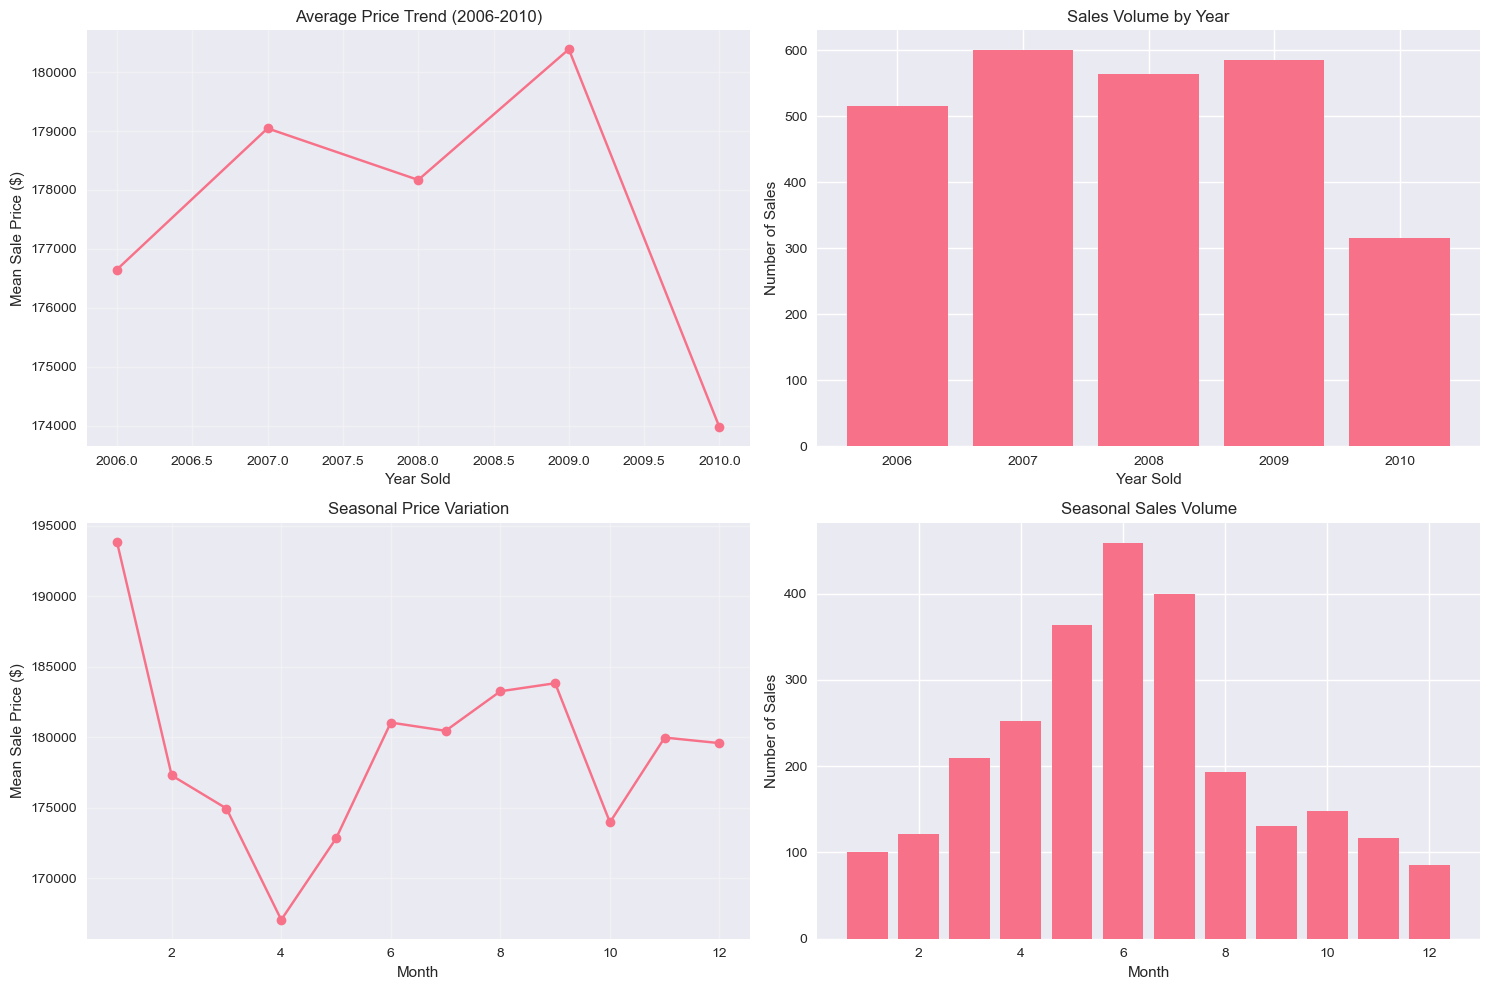


Recession Impact Analysis:
Pre-recession (2006-2007): $177,937
During recession (2008-2009): $179,299
Post-recession (2010): $173,972
Peak to trough decline: 0.8%


In [4]:
# ==========================================
# PHASE 3: KEY INSIGHTS ANALYSIS
# ==========================================

print("\n" + "="*50)
print("PHASE 3: KEY INSIGHTS ANALYSIS")
print("="*50)

# 1. NEIGHBORHOOD ANALYSIS
print("\n1. NEIGHBORHOOD ANALYSIS")
print("-" * 25)

neighborhood_stats = housing.groupby('Neighborhood').agg({
    'SalePrice': ['mean', 'median', 'count'],
    'PricePerSqFt': ['mean', 'median'],
    'GrLivArea': 'mean',
    'HouseAge': 'mean',
    'OverallQual': 'mean'
}).round(2)

neighborhood_stats.columns = ['_'.join(col).strip() for col in neighborhood_stats.columns]
neighborhood_stats = neighborhood_stats.sort_values('SalePrice_mean', ascending=False)

print("Top 10 Most Expensive Neighborhoods:")
print(neighborhood_stats.head(10)[['SalePrice_mean', 'PricePerSqFt_mean', 'GrLivArea_mean']])

print("\nBottom 5 Least Expensive Neighborhoods:")
print(neighborhood_stats.tail(5)[['SalePrice_mean', 'PricePerSqFt_mean', 'GrLivArea_mean']])

# Visualize neighborhood prices
plt.figure(figsize=(15, 8))
top_neighborhoods = neighborhood_stats.head(15).index
housing_top = housing[housing['Neighborhood'].isin(top_neighborhoods)]

plt.subplot(1, 2, 1)
sns.boxplot(data=housing_top, y='Neighborhood', x='SalePrice', 
            order=top_neighborhoods)
plt.title('Sale Prices by Top 15 Neighborhoods')
plt.xlabel('Sale Price ($)')

plt.subplot(1, 2, 2)
sns.boxplot(data=housing_top, y='Neighborhood', x='PricePerSqFt', 
            order=top_neighborhoods)
plt.title('Price per Sq Ft by Top 15 Neighborhoods')
plt.xlabel('Price per Sq Ft ($)')

plt.tight_layout()
plt.show()

# 2. QUALITY VS PRICE ANALYSIS
print("\n2. QUALITY VS PRICE ANALYSIS")
print("-" * 28)

# Overall Quality impact
quality_stats = housing.groupby('OverallQual').agg({
    'SalePrice': ['mean', 'count'],
    'PricePerSqFt': 'mean'
}).round(2)

print("Price by Overall Quality Rating:")
print(quality_stats)

# Create quality visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Overall Quality vs Price
axes[0,0].scatter(housing['OverallQual'], housing['SalePrice'], alpha=0.6)
axes[0,0].set_xlabel('Overall Quality')
axes[0,0].set_ylabel('Sale Price ($)')
axes[0,0].set_title('Price vs Overall Quality')

# Kitchen Quality impact
kitchen_order = ['Fa', 'TA', 'Gd', 'Ex']  # Fair, Typical, Good, Excellent
housing_kitchen = housing[housing['KitchenQual'].isin(kitchen_order)]
sns.boxplot(data=housing_kitchen, x='KitchenQual', y='SalePrice', 
            order=kitchen_order, ax=axes[0,1])
axes[0,1].set_title('Price vs Kitchen Quality')

# Exterior Quality impact
exterior_order = ['Fa', 'TA', 'Gd', 'Ex']
housing_exterior = housing[housing['ExterQual'].isin(exterior_order)]
sns.boxplot(data=housing_exterior, x='ExterQual', y='SalePrice', 
            order=exterior_order, ax=axes[1,0])
axes[1,0].set_title('Price vs Exterior Quality')

# Quality Score vs Price
axes[1,1].scatter(housing['QualityScore'], housing['SalePrice'], alpha=0.6)
axes[1,1].set_xlabel('Quality Score (Overall Qual × Overall Cond)')
axes[1,1].set_ylabel('Sale Price ($)')
axes[1,1].set_title('Price vs Combined Quality Score')

plt.tight_layout()
plt.show()

# 3. TIME TRENDS ANALYSIS
print("\n3. TIME TRENDS ANALYSIS (2006-2010)")
print("-" * 35)

# Yearly trends
yearly_stats = housing.groupby('YrSold').agg({
    'SalePrice': ['mean', 'median', 'count'],
    'PricePerSqFt': ['mean', 'median']
}).round(2)

print("Price Trends by Year:")
print(yearly_stats)

# Monthly seasonality
monthly_stats = housing.groupby('MoSold').agg({
    'SalePrice': ['mean', 'count']
}).round(2)

print("\nMonthly Seasonality:")
print(monthly_stats)

# Visualize time trends
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Yearly trends
axes[0,0].plot(yearly_stats.index, yearly_stats[('SalePrice', 'mean')], 'o-')
axes[0,0].set_xlabel('Year Sold')
axes[0,0].set_ylabel('Mean Sale Price ($)')
axes[0,0].set_title('Average Price Trend (2006-2010)')
axes[0,0].grid(True, alpha=0.3)

# Transaction volume by year
axes[0,1].bar(yearly_stats.index, yearly_stats[('SalePrice', 'count')])
axes[0,1].set_xlabel('Year Sold')
axes[0,1].set_ylabel('Number of Sales')
axes[0,1].set_title('Sales Volume by Year')

# Monthly seasonality - price
axes[1,0].plot(monthly_stats.index, monthly_stats[('SalePrice', 'mean')], 'o-')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Mean Sale Price ($)')
axes[1,0].set_title('Seasonal Price Variation')
axes[1,0].grid(True, alpha=0.3)

# Monthly seasonality - volume
axes[1,1].bar(monthly_stats.index, monthly_stats[('SalePrice', 'count')])
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Number of Sales')
axes[1,1].set_title('Seasonal Sales Volume')

plt.tight_layout()
plt.show()

# Calculate price change during recession
pre_recession = housing[housing['YrSold'] <= 2007]['SalePrice'].mean()
recession = housing[housing['YrSold'].isin([2008, 2009])]['SalePrice'].mean()
post_recession = housing[housing['YrSold'] == 2010]['SalePrice'].mean()

print(f"\nRecession Impact Analysis:")
print(f"Pre-recession (2006-2007): ${pre_recession:,.0f}")
print(f"During recession (2008-2009): ${recession:,.0f}")
print(f"Post-recession (2010): ${post_recession:,.0f}")
print(f"Peak to trough decline: {((recession - pre_recession) / pre_recession * 100):.1f}%")


PHASE 4: COMPREHENSIVE DESCRIPTIVE MODELING
Using 22 features for modeling

Model Performance:
Training R²: 0.8616
Testing R²: 0.8507
RMSE: $30,305

Top 15 Most Important Features:
                feature   coefficient
4        LotUtilization -42727.303629
13              HasPool  22683.200406
18    ExterQual_encoded -14584.006577
5           OverallQual  13579.595766
14           Fireplaces  10104.591119
11            HasGarage  -9611.066651
6           OverallCond   8526.680062
2             TotalBath   5264.460687
19  KitchenQual_encoded  -4674.544816
10           HasRemodel   3424.853225
21   CentralAir_encoded   1703.120141
20    HeatingQC_encoded   -666.969459
8              HouseAge   -381.236163
15     MSZoning_encoded   -374.190407
7          QualityScore   -282.739190


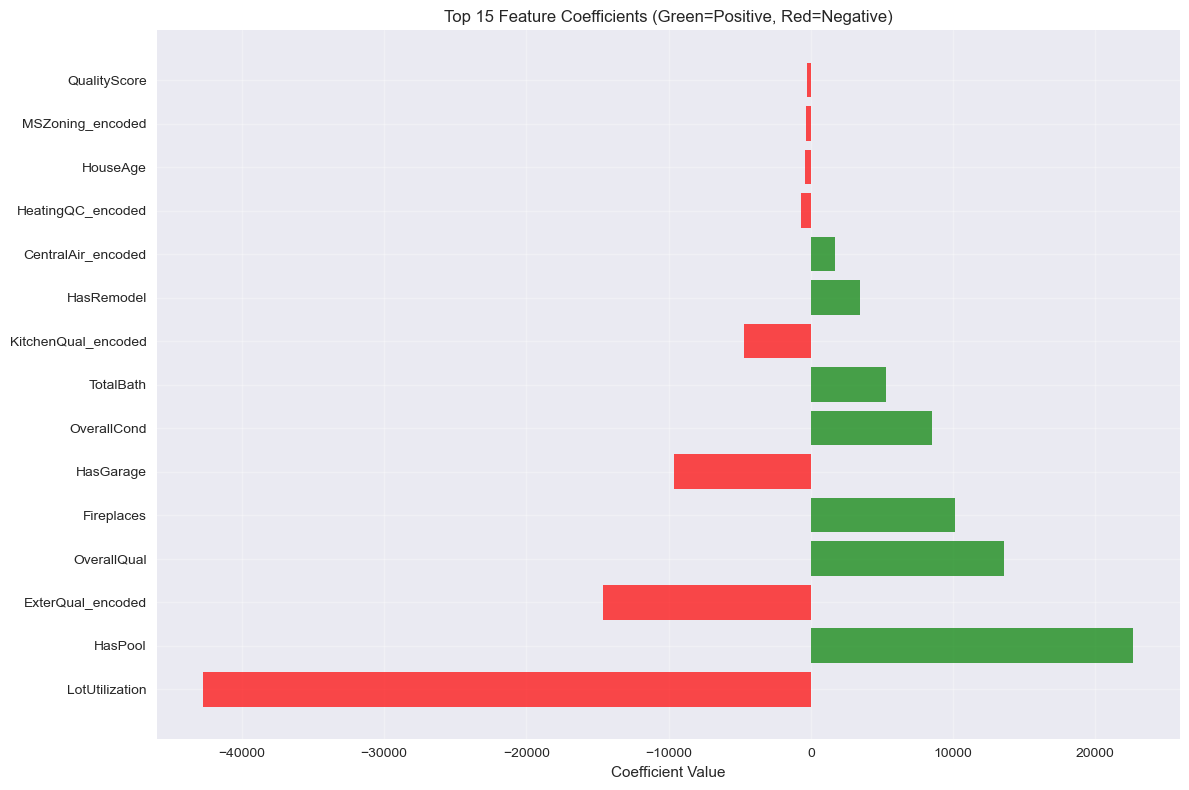

In [5]:
# ==========================================
# PHASE 4: COMPREHENSIVE MODELING
# ==========================================

print("\n" + "="*50)
print("PHASE 4: COMPREHENSIVE DESCRIPTIVE MODELING")
print("="*50)

# Prepare features for modeling
features_for_modeling = [
    'GrLivArea', 'TotalArea', 'TotalBath', 'LotArea', 'LotUtilization',
    'OverallQual', 'OverallCond', 'QualityScore', 'HouseAge', 'TimeSinceRemodel',
    'HasRemodel', 'HasGarage', 'GarageArea', 'HasPool', 'Fireplaces'
]

# Add encoded categorical features
encoded_features = [col for col in housing.columns if col.endswith('_encoded')]
features_for_modeling.extend(encoded_features)

# Remove features with missing values for simplicity
available_features = [f for f in features_for_modeling if f in housing.columns and housing[f].notna().all()]
print(f"Using {len(available_features)} features for modeling")

# Create model dataset
X = housing[available_features].fillna(0)
y = housing['SalePrice']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit comprehensive model
model = LinearRegression()
model.fit(X_train, y_train)

# Model performance
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
y_pred = model.predict(X_test)

print(f"\nModel Performance:")
print(f"Training R²: {train_score:.4f}")
print(f"Testing R²: {test_score:.4f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred)):,.0f}")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': available_features,
    'coefficient': model.coef_,
    'abs_coefficient': np.abs(model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print(f"\nTop 15 Most Important Features:")
print(feature_importance.head(15)[['feature', 'coefficient']])

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
colors = ['green' if x > 0 else 'red' for x in top_features['coefficient']]
plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 15 Feature Coefficients (Green=Positive, Red=Negative)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# ==========================================
# PHASE 5: BUSINESS INSIGHTS & RECOMMENDATIONS
# ==========================================

print("\n" + "="*50)
print("PHASE 5: BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*50)

print("\n🏠 KEY FINDINGS:")
print("-" * 15)

print("\n1. PRICE STRUCTURE INSIGHTS:")
print(f"   • Larger homes have lower price per sq ft (${housing['PricePerSqFt'].mean():.0f} average)")
print(f"   • Log-log model explains {r2_log:.1%} of price variation")
print(f"   • Price elasticity of {beta_1:.3f} indicates economies of scale")

print("\n2. NEIGHBORHOOD PREMIUM/DISCOUNT:")
top_3_neighborhoods = neighborhood_stats.head(3).index.tolist()
bottom_3_neighborhoods = neighborhood_stats.tail(3).index.tolist()
print(f"   • Premium neighborhoods: {', '.join(top_3_neighborhoods)}")
print(f"   • Value neighborhoods: {', '.join(bottom_3_neighborhoods)}")

premium_avg = neighborhood_stats.head(3)['SalePrice_mean'].mean()
value_avg = neighborhood_stats.tail(3)['SalePrice_mean'].mean()
print(f"   • Premium vs Value price gap: {((premium_avg - value_avg) / value_avg * 100):.0f}%")

print("\n3. QUALITY IMPACT:")
quality_premium = (housing[housing['OverallQual'] >= 8]['SalePrice'].mean() - 
                  housing[housing['OverallQual'] <= 5]['SalePrice'].mean())
print(f"   • High quality (8-10) vs Average quality (≤5) premium: ${quality_premium:,.0f}")

print("\n4. MARKET TIMING:")
peak_month = monthly_stats[('SalePrice', 'mean')].idxmax()
low_month = monthly_stats[('SalePrice', 'mean')].idxmin()
print(f"   • Best selling month: {peak_month} (highest prices)")
print(f"   • Buyer's market: Month {low_month} (lowest prices)")
print(f"   • Recession impact: {((recession - pre_recession) / pre_recession * 100):.1f}% price decline")


PHASE 5: BUSINESS INSIGHTS & RECOMMENDATIONS

🏠 KEY FINDINGS:
---------------

1. PRICE STRUCTURE INSIGHTS:
   • Larger homes have lower price per sq ft ($121 average)
   • Log-log model explains 54.0% of price variation
   • Price elasticity of 0.881 indicates economies of scale

2. NEIGHBORHOOD PREMIUM/DISCOUNT:
   • Premium neighborhoods: NoRidge, NridgHt, StoneBr
   • Value neighborhoods: IDOTRR, BrDale, MeadowV
   • Premium vs Value price gap: 204%

3. QUALITY IMPACT:
   • High quality (8-10) vs Average quality (≤5) premium: $169,905

4. MARKET TIMING:
   • Best selling month: 1 (highest prices)
   • Buyer's market: Month 4 (lowest prices)
   • Recession impact: 0.8% price decline


In [7]:
# ==========================================
# BUSINESS APPLICATION: STUDENT RENTAL INVESTMENT
# ==========================================

print("\n" + "="*60)
print("BUSINESS APPLICATION: STUDENT RENTAL INVESTMENT ANALYSIS")
print("="*60)

# Define investment criteria for student rentals
print("\n🎯 INVESTMENT STRATEGY FOR STUDENT RENTALS:")
print("-" * 45)

# Identify target characteristics for student rentals
student_rental_criteria = {
    'price_max': 200000,  # Affordable for investment
    'bedrooms_min': 3,    # Multiple students
    'age_max': 50,        # Not too old
    'area_min': 1200      # Reasonable size
}

# Filter suitable properties
suitable_properties = housing[
    (housing['SalePrice'] <= student_rental_criteria['price_max']) &
    (housing['BedroomAbvGr'] >= student_rental_criteria['bedrooms_min']) &
    (housing['HouseAge'] <= student_rental_criteria['age_max']) &
    (housing['GrLivArea'] >= student_rental_criteria['area_min'])
]

print(f"\n📊 MARKET ANALYSIS:")
print(f"   • Total properties in dataset: {len(housing):,}")
print(f"   • Properties meeting student rental criteria: {len(suitable_properties):,}")
print(f"   • Market opportunity: {len(suitable_properties)/len(housing):.1%} of total market")

if len(suitable_properties) > 0:
    print(f"\n💰 INVESTMENT TARGETS:")
    print(f"   • Average purchase price: ${suitable_properties['SalePrice'].mean():,.0f}")
    print(f"   • Price range: ${suitable_properties['SalePrice'].min():,.0f} - ${suitable_properties['SalePrice'].max():,.0f}")
    print(f"   • Average size: {suitable_properties['GrLivArea'].mean():.0f} sq ft")
    print(f"   • Average bedrooms: {suitable_properties['BedroomAbvGr'].mean():.1f}")
    
    # Best neighborhoods for student rentals
    student_neighborhoods = suitable_properties['Neighborhood'].value_counts().head(5)
    print(f"\n🏘️  TOP NEIGHBORHOODS FOR STUDENT RENTALS:")
    for neighborhood, count in student_neighborhoods.items():
        avg_price = suitable_properties[suitable_properties['Neighborhood'] == neighborhood]['SalePrice'].mean()
        print(f"   • {neighborhood}: {count} properties, avg ${avg_price:,.0f}")
    
    # Calculate investment returns
    avg_purchase_price = suitable_properties['SalePrice'].mean()
    annual_maintenance = avg_purchase_price * 0.02  # 2% maintenance
    annual_tax = avg_purchase_price * 0.015         # 1.5% property tax
    
    # Estimate rental income (assuming $400-500 per bedroom per month)
    avg_bedrooms = suitable_properties['BedroomAbvGr'].mean()
    monthly_rent = avg_bedrooms * 450  # $450 per bedroom
    annual_rent = monthly_rent * 12
    
    net_annual_income = annual_rent - annual_maintenance - annual_tax
    roi = (net_annual_income / avg_purchase_price) * 100
    
    print(f"\n💵 FINANCIAL PROJECTIONS:")
    print(f"   • Average purchase price: ${avg_purchase_price:,.0f}")
    print(f"   • Estimated monthly rent: ${monthly_rent:,.0f} ({avg_bedrooms:.1f} bedrooms × $450)")
    print(f"   • Annual rental income: ${annual_rent:,.0f}")
    print(f"   • Annual expenses: ${annual_maintenance + annual_tax:,.0f}")
    print(f"     - Maintenance (2%): ${annual_maintenance:,.0f}")
    print(f"     - Property tax (1.5%): ${annual_tax:,.0f}")
    print(f"   • Net annual income: ${net_annual_income:,.0f}")
    print(f"   • Return on Investment: {roi:.1f}%")

print(f"\n✅ RECOMMENDATIONS:")
print(f"   1. Focus on neighborhoods with multiple suitable properties")
print(f"   2. Target 3-4 bedroom homes under $200K")
print(f"   3. Prioritize properties near campus (check ISU proximity)")
print(f"   4. Consider properties built after 1970 for lower maintenance")
print(f"   5. Budget for renovations to make properties student-friendly")

print(f"\n" + "="*60)
print("ANALYSIS COMPLETE")
print("="*60)
print("This analysis provides a data-driven foundation for understanding")
print("the Ames housing market and making informed investment decisions.")


BUSINESS APPLICATION: STUDENT RENTAL INVESTMENT ANALYSIS

🎯 INVESTMENT STRATEGY FOR STUDENT RENTALS:
---------------------------------------------

📊 MARKET ANALYSIS:
   • Total properties in dataset: 2,580
   • Properties meeting student rental criteria: 524
   • Market opportunity: 20.3% of total market

💰 INVESTMENT TARGETS:
   • Average purchase price: $167,298
   • Price range: $82,500 - $200,000
   • Average size: 1574 sq ft
   • Average bedrooms: 3.3

🏘️  TOP NEIGHBORHOODS FOR STUDENT RENTALS:
   • NAmes: 101 properties, avg $157,607
   • Gilbert: 99 properties, avg $179,114
   • NWAmes: 64 properties, avg $173,700
   • CollgCr: 51 properties, avg $185,000
   • SawyerW: 36 properties, avg $176,253

💵 FINANCIAL PROJECTIONS:
   • Average purchase price: $167,298
   • Estimated monthly rent: $1,476 (3.3 bedrooms × $450)
   • Annual rental income: $17,715
   • Annual expenses: $5,855
     - Maintenance (2%): $3,346
     - Property tax (1.5%): $2,509
   • Net annual income: $11,859
